# Visualisation of the DynAstVO database

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from packages.dataCleaner import cleanData
from packages.chunkReader import readByChunks, concatenate

## Cleaning the data file

The raw file contains Optical, Spatial and Radar observations, which are written in the text file using different formats. We need to clean this file in order to work with the data. We split the file into 2 distinct files, suppressing every useless line of data (object header and the position of a satellite in the case of spatial observation)

In [2]:
INPUT_FILE = 'Data\\OMC20200621.txt'
OPTICAL_SPACE_OUTPUT_FILE = 'Data\\OpticalSpaceData.txt'
RADAR_OUTPUT_FILE = 'Data\\RadarData.txt'

cleanData(INPUT_FILE, OPTICAL_SPACE_OUTPUT_FILE, RADAR_OUTPUT_FILE)

2571320it [00:09, 265738.05it/s]


## Reading the data

### Optical and Spatial data

Firstly, we give a name to every column (cf documentation), and we read the file, previously separated according to the type of observation.
We start with the optical and spatial observations together in the same Dataframe because they have the same format.

In [3]:

OScolnames = {'obs_type': 'category',
              'measure_type': 'category',
              'year': np.uint16,
              'month': np.uint8,
              'day': np.float64,
              'RA': np.float64,
              'DEC': np.float64,
              'obs_code': 'category',
              'RA_bias_correction': np.float32,
              'DEC_bias_correction': np.float32,
              'RA_precision': np.float64,
              'DEC_precision': np.float64,
              'acceptance': 'bool',
              'catalog': 'category',
              'mag': np.float64,
              'nbr_obs': np.float16,
              'random_number': np.float64,
              'RA_delta': np.float64,
              'DEC_delta': np.float64,
              'xhi_square': np.float64,
              'mag_acceptance': np.float16,
              'mag_delta': np.float64,
              'object_number': 'category'}
LINES_PER_CHUNK = 100000
OSdata = readByChunks("Data\\OpticalSpaceData.txt", OScolnames, LINES_PER_CHUNK)


### Radar Data

We repeat this step for the Radar data, which uses a different format.

In [4]:
RadarColnames = {'obs_type': 'category',
                 'measure_type': 'category',
                 'year': np.uint16,
                 'month': np.uint8,
                 'day': np.float64,
                 'Distance/Velocity': np.float64,
                 'c': 'category',
                 'obs_code_tr': 'category',
                 'obs_code_rc': 'category',
                 'bias_correction': np.float32,
                 'precision': np.float64,
                 'acceptance': 'bool',
                 'RA_delta': np.float64,
                 'xhi_square': np.float64,
                 'object_number': 'category'}

Rdata = readByChunks("Data\\RadarData.txt", RadarColnames, LINES_PER_CHUNK)

## Most important observatories

Some observatories are publishing a lot more data than others, and so are more reliable. Let's try to visualise which observatories are the most important by ploting the number of observations per observatory.

In [5]:
N_OBS = 20
BEST_OBS_LIST = list(OSdata['obs_code'].value_counts().head(N_OBS).index)

[Text(0, 0.5, 'Total number of observations'),
 Text(0.5, 0, 'Observatory code'),
 Text(0.5, 1.0, 'Number of observations by the 20 most active observatories')]

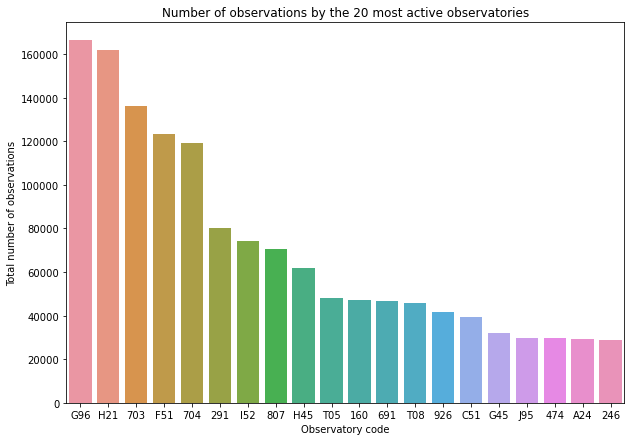

In [6]:
# plot the number of observations for the 20 bigest observatories
plt.figure(figsize=(10,7))
ax = sns.countplot(x='obs_code', data=OSdata, order=BEST_OBS_LIST)
ax.set(xlabel='Observatory code', ylabel='Total number of observations', title=f'Number of observations by the {N_OBS} most active observatories')

We can notice that the observatory G96 is the greatest contributor. This code corresponds to the Mt. Lemmon Survey observatory. The second greatest contributor, H21, is the Astronomical Research Observatory, Westfield. The full list can be found here https://minorplanetcenter.net/iau/lists/ObsCodesF.html 

## Precision over time

With hardware improvements and new software, we can expect the precision of the observations to be better over time. We will verify this assumption for the best observatories.

### Standard deviation of the best observatories combined

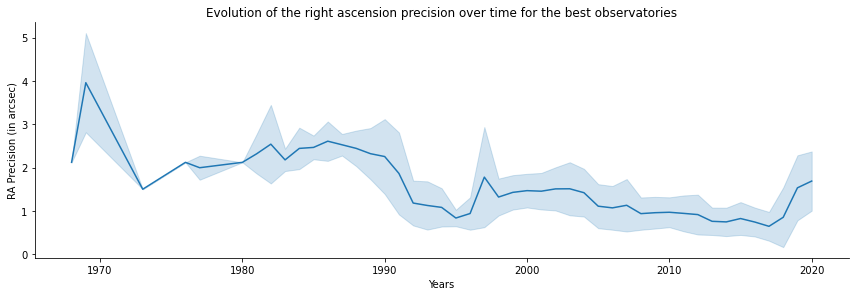

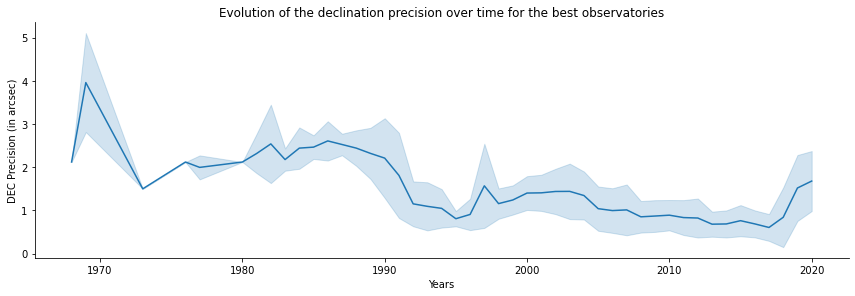

In [7]:
ax = sns.relplot(x='year', y='RA_precision', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA Precision (in arcsec)', title='Evolution of the right ascension precision over time for the best observatories')

ax = sns.relplot(x='year', y='DEC_precision', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC Precision (in arcsec)', title='Evolution of the declination precision over time for the best observatories')


### Evolution of the precision over time for the 5 best observatories 

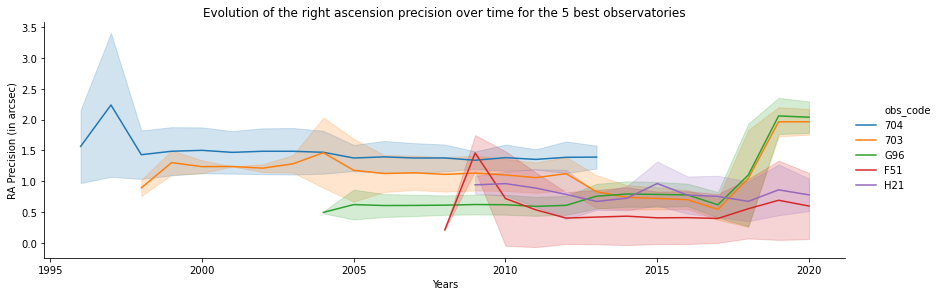

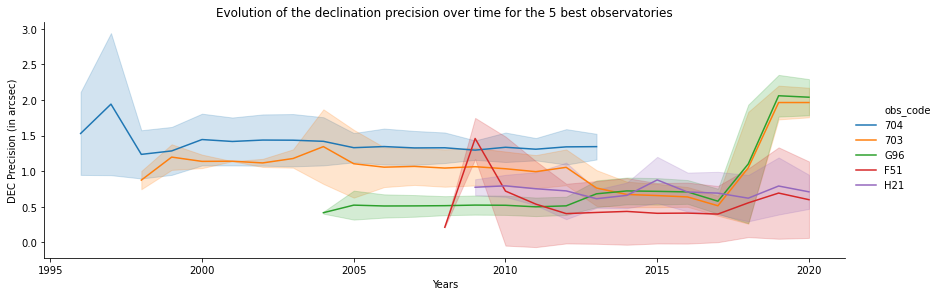

In [8]:
ax = sns.relplot(x='year', y='RA_precision', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 1995)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA Precision (in arcsec)', title='Evolution of the right ascension precision over time for the 5 best observatories')

ax = sns.relplot(x='year', y='DEC_precision', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 1995)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC Precision (in arcsec)', title='Evolution of the declination precision over time for the 5 best observatories')
